In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('../data/processed/movies.csv')

In [7]:
df.head(3)

,Unnamed: 0,genres,keywords,popularity,title,vote_average,vote_count,movie_id,cast,crew
0,0,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['culture clash', 'future', 'space war', 'spac...",150.437577,Avatar,7.2,11800,19995,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",['James Cameron']
1,1,"['Adventure', 'Fantasy', 'Action']","['ocean', 'drug abuse', 'exotic island', 'east...",139.082615,Pirates of the Caribbean: At World's End,6.9,4500,285,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",['Gore Verbinski']
2,2,"['Action', 'Adventure', 'Crime']","['spy', 'based on novel', 'secret agent', 'seq...",107.376788,Spectre,6.3,4466,206647,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",['Sam Mendes']


# Demographic Filtering

Including a Now Trending system is a quick and easy way to find movies that are very popular. We need to define a to rate films using both average rating and rating count. We'll be using IMDB's rating formula. Weighted Rating
\begin{equation}
WR = (v/v+m) * R + (m/v+m) * C
\end{equation}




Where, 

-  v is the number of votes for the movie
-  m is the min votes required to be in the list
-  R is the average rating of the movie
-  C is the mean vote across the report

In [15]:
C = df['vote_average'].mean()
print(f'The average movie rating for our dataset is: {round(C,2)}')

The average movie rating for our dataset is: 6.11


In [16]:
m = df['vote_count'].quantile(.9)
m

1862.0

Let's now remove movies that do not make the cut

In [18]:
qualified_m = df.copy().loc[df['vote_count'] >= m]

In [19]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)


Let us apply our fomula to our movie dataset

In [21]:
qualified_m['score'] = qualified_m.apply(weighted_rating, axis=1)


In [22]:
#Sort movies based on score calculated above
qualified_m = qualified_m.sort_values('score', ascending=False)

#Print the top 15 movies
qualified_m[['title', 'vote_count', 'vote_average', 'score']].head(10)


,title,vote_count,vote_average,score
1887,The Shawshank Redemption,8205,8.5,8.058779
662,Fight Club,9413,8.3,7.939080
65,The Dark Knight,12002,8.2,7.919910
3237,Pulp Fiction,8428,8.3,7.904531
96,Inception,13752,8.1,7.863227
3342,The Godfather,5893,8.4,7.851248
95,Interstellar,10867,8.1,7.809563
809,Forrest Gump,7927,8.2,7.803313
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727547
1996,The Empire Strikes Back,5879,8.2,7.698363


We have now identified how IMDB ranks their movies


Text(0.5, 1.0, 'Popular Movies')

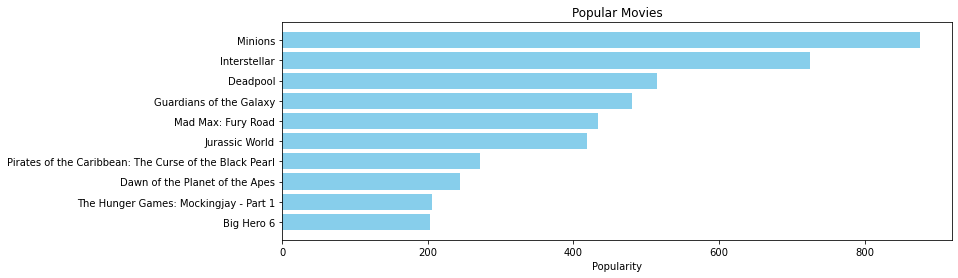

In [24]:
import matplotlib.pyplot as plt
pop = df.sort_values('popularity', ascending=False)
plt.figure(figsize=(12, 4))

plt.barh(pop['title'].head(10), pop['popularity'].head(10), align='center',
         color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


# Content Filtering

Content based filtering uses different criterias when recommending movies. For example, we can recommend movies based on cast, crew and story plot. 

We need to convert names and keywords instances into lowercase and strip all the spaces between them so our CountVectorizer doesn't count them as two different instances of the same observation.

In [25]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


Our content filtering system is going to use the features below to compare films and return similar titles.

In [28]:

features = ['cast', 'keywords', 'crew', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)



We need to create a column that contains the metadata of our features.

In [30]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['crew'] + ' ' + ' '.join(x['genres'])
df['soup'] = df.apply(create_soup, axis=1)

In [32]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)


In [34]:
df = df.reset_index()
indices = pd.Series(df.index, index=df['title'])

In [36]:
def get_recommendations(title, cosine_sim=cosine_sim2):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [43]:
get_recommendations('The Dark Knight Rises', cosine_sim2)


65                               The Dark Knight
95                                  Interstellar
96                                     Inception
119                                Batman Begins
1036                                    Insomnia
1199                                The Prestige
3578                                     Memento
0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
Name: title, dtype: object

# Collaborative Filtering

The idea of collaborative filtering is based on the idea that users similar to me can be used to predict how much I will like a particular product or service using their experience. 

Our system will follow theses steps:

-   Get user input
-   Based on user input our system will return similar users
-   Get the most rated movies for similar users and calculate smilarity score
-   Recommend highest scored movies back to user

In [57]:
movies_df = pd.read_csv('../data/processed/collab_movies.csv')
ratings_df = pd.read_csv('../data/processed/collab_ratings.csv')

In [58]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))', expand=False)
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)', expand=False)
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())


<ipython-input-58-e963abcf08f2>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')


In [59]:
ratings_df = ratings_df.drop('timestamp', 1)


<ipython-input-59-9d694ad7ac4e>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ratings_df = ratings_df.drop('timestamp', 1)


In [104]:
input_user = [
    {'title': 'Remember the Titans', 'rating': 3},
    {'title': 'Transformers', 'rating': 3},
    {'title': 'Happy Gilmore', 'rating': 4},
    {'title': "Interstellar", 'rating': 5},
    {'title': 'The Lion King', 'rating': 3.5},
    {'title': 'Gravity', 'rating': 3.5},
    {'title': 'Titanic', 'rating': 3},
    {'title': 'Start Wars', 'rating': 5},
    {'title': 'The Godfather', 'rating': 5}
    
]
input_movies = pd.DataFrame(input_user)
input_movies


,title,rating
0,Remember the Titans,3.0
1,Transformers,3.0
2,Happy Gilmore,4.0
3,Interstellar,5.0
4,The Lion King,3.5
5,Gravity,3.5
6,Titanic,3.0
7,Start Wars,5.0
8,The Godfather,5.0


In [105]:
inputId = movies_df[movies_df['title'].isin(input_movies['title'].tolist())]
input_movies = pd.merge(inputId, input_movies)
input_movies = input_movies.drop('year', 1)
input_movies


<ipython-input-105-c6d4f4cbeeb6>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  input_movies = input_movies.drop('year', 1)


,movieId,title,genres,rating
0,104,Happy Gilmore,Comedy,4.0
1,1721,Titanic,Drama|Romance,3.0
2,3404,Titanic,Action|Drama,3.0
3,118916,Titanic,Action|Drama|Romance,3.0
4,181653,Titanic,Action|Drama,3.0
5,3916,Remember the Titans,Drama,3.0
6,53996,Transformers,Action|Sci-Fi|Thriller|IMAX,3.0
7,104841,Gravity,Action|Sci-Fi|IMAX,3.5
8,109487,Interstellar,Sci-Fi|IMAX,5.0


In [106]:
similar_users = ratings_df[ratings_df['movieId'].isin(
    input_movies['movieId'].tolist())]
similar_users.head()


,userId,movieId,rating
37,83438,1721,4.5
70,83439,104,5.0
263,83439,109487,3.5
481,83444,1721,2.0
1500,83450,1721,1.0


In [107]:
grouped_users = similar_users.groupby(['userId'])
grouped_users.get_group(83439)


,userId,movieId,rating
70,83439,104,5.0
263,83439,109487,3.5


In [108]:
grouped_users = sorted(grouped_users,  key=lambda x: len(x[1]), reverse=True)
grouped_users[:2]


[(94843,
           userId  movieId  rating
  1086076   94843      104     0.5
  1087042   94843     1721     1.0
  1087811   94843     3404     0.5
  1088008   94843     3916     0.5
  1089279   94843    53996     0.5
  1090243   94843   104841     0.5
  1090316   94843   109487     0.5),
 (83579,
         userId  movieId  rating
  18949   83579      104     3.0
  19562   83579     1721     3.5
  20150   83579     3916     3.5
  21115   83579    53996     3.0
  21607   83579   109487     3.0
  21648   83579   118916     3.0)]

In [109]:
grouped_users = grouped_users[0:100]


In [110]:
from numpy import sqrt
correlateDict = {}
for name, group in grouped_users:
    group = group.sort_values(by='movieId')
    inputMovies = input_movies.sort_values(by='movieId')
    nRatings = len(group)
    temp_df = input_movies[input_movies['movieId'].isin(
        group['movieId'].tolist())]
    tempRatingList = temp_df['rating'].tolist()
    tempGroupList = group['rating'].tolist()
    Sxx = sum([i**2 for i in tempRatingList]) - \
        pow(sum(tempRatingList), 2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - \
        pow(sum(tempGroupList), 2)/float(nRatings)
    Sxy = sum(i*j for i, j in zip(tempRatingList, tempGroupList)) - \
        sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    if Sxx != 0 and Syy != 0:
        correlateDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        correlateDict[name] = 0


In [111]:


correlateDF = pd.DataFrame.from_dict(correlateDict, orient='index')
correlateDF.columns = ['similarityIndex']
correlateDF['userId'] = correlateDF.index
correlateDF.index = range(len(correlateDF))
correlateDF.head()


,similarityIndex,userId
0,-0.288675,94843
1,-0.462910,83579
2,-0.331111,85692
3,0.481046,86956
4,0.113961,88506


In [112]:
similarusers = correlateDF.sort_values(
    by='similarityIndex', ascending=False)[0:50]
similarusers.head()


,similarityIndex,userId
70,0.985451,90298
65,0.916667,89367
75,0.906327,90725
93,0.870109,97298
69,0.866921,89864


In [113]:


similarusrsrating = similarusers.merge(
    ratings_df, left_on='userId', right_on='userId', how='inner')
similarusrsrating.head()


,similarityIndex,userId,movieId,rating
0,0.985451,90298,1,3.5
1,0.985451,90298,2,2.5
2,0.985451,90298,6,3.5
3,0.985451,90298,9,3.0
4,0.985451,90298,10,4.5


In [114]:

similarusrsrating['weightedRating'] = similarusrsrating['similarityIndex'] * \
    similarusrsrating['rating']
similarusrsrating.head()


,similarityIndex,userId,movieId,rating,weightedRating
0,0.985451,90298,1,3.5,3.449078
1,0.985451,90298,2,2.5,2.463627
2,0.985451,90298,6,3.5,3.449078
3,0.985451,90298,9,3.0,2.956353
4,0.985451,90298,10,4.5,4.434529


In [115]:
tmpsimilarusrsrating = similarusrsrating.groupby(
    'movieId').sum()[['similarityIndex', 'weightedRating']]
tmpsimilarusrsrating.columns = ['sum_similarityIndex', 'sum_weightedRating']
tmpsimilarusrsrating.head()


,sum_similarityIndex,sum_weightedRating
movieId,,
1,26.366826,92.628127
2,22.254254,68.180462
3,5.489462,15.583212
4,0.523752,1.833132
5,6.438959,16.830313


In [116]:
recommend_movies = pd.DataFrame()
recommend_movies['weighted recom score'] = tmpsimilarusrsrating['sum_weightedRating'] / \
    tmpsimilarusrsrating['sum_similarityIndex']
recommend_movies['movieId'] = tmpsimilarusrsrating.index
recommend_movies.head()


,weighted recom score,movieId
movieId,,
1,3.513056,1
2,3.063705,2
3,2.838750,3
4,3.500000,4
5,2.613825,5


In [117]:
recommend_movies = recommend_movies.sort_values(
    by='weighted recom score', ascending=False)
recommend_movies.head()


,weighted recom score,movieId
movieId,,
4939,5.0,4939
108540,5.0,108540
107130,5.0,107130
125972,5.0,125972
53140,5.0,53140


In [118]:
movies_df.loc[movies_df['movieId'].isin(
    recommend_movies.head()['movieId'].tolist())]


,movieId,title,genres,year
4844,4939,"Final Countdown, The",Action|Sci-Fi,1980
11907,53140,"Librarian: Quest for the Spear, The",Action|Adventure|Comedy|Fantasy|Romance,2004
22557,107130,"Adventure in Space and Time, An",Drama,2013
22974,108540,Ernest & Célestine (Ernest et Célestine),Adventure|Animation|Children|Comedy|Drama|Romance,2012
28869,125972,Halloweentown II: Kalabar's Revenge,Adventure|Children|Comedy|Drama|Fantasy,2001
